In [1]:
import os
import glob
import json
import torch
import requests
import html2text

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer, AutoModelForQuestionAnswering, pipeline

from googlesearch import search

data_path = "../../data"

In [43]:
root_path = os.path.join(data_path, "okvqa")

test_questions_path = os.path.join(root_path, "OpenEnded_mscoco_val2014_questions.json")
test_annotations_path = os.path.join(root_path, "mscoco_val2014_annotations.json")
test_image_path = os.path.join(root_path, "val2014")
test_image_name_prefix = "COCO_val2014_000000"

with open(test_questions_path, "r") as f:
    test_questions_df = pd.DataFrame(json.load(f)["questions"])
    
with open(test_annotations_path, "r") as f:
    test_annotations_df = pd.DataFrame(json.load(f)["annotations"])
    
test_df = test_questions_df.merge(test_annotations_df)
test_df["image_path"] = test_df["image_id"].map(lambda image_id: os.path.join(test_image_path, f"{test_image_name_prefix}{image_id:06d}.jpg"))

In [3]:
qa_model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
qa_tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")

ic_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
ic_feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
ic_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qa_model.to(device)

ic_model.to(device)

nlp = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)

In [30]:
def read_image(image_path):
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")

    return i_image

def get_context_google(caption):
    links = list(search(caption, num_results=5))

    html_conv = html2text.HTML2Text()
    html_conv.ignore_links = True
    html_conv.escape_all = True

    text = []
    for link in links:
        req = requests.get(link)
        text.append(html_conv.handle(req.text))

    return " ".join(text)

def ic_predict_step(image, max_length=16, num_beams=4):
    pixel_values = ic_feature_extractor(images=[image], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = ic_model.generate(pixel_values, max_length=max_length, num_beams=num_beams)

    preds = ic_tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds[0]

def qa_predict_step(qa_input):
    return nlp(qa_input)

def mk_predictions(index):
    question, image_path, answers = test_df[["question", "image_path", "answers"]].iloc[index]
    image = read_image(image_path)
    caption = ic_predict_step(image)
    answer = qa_predict_step({
        'question': question,
        'context': get_context_google(caption)
    })

    plt.imshow(image)
    plt.show()
    print(f"Q: {question}\nC: {caption}\nA: {answer['answer']} (score:{answer['score']})\nGT: {answers[0]['answer']}")

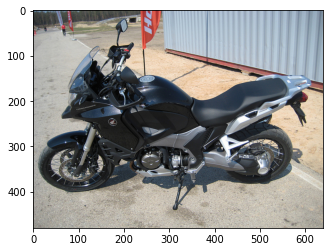

Q: What sport can you use this for?
C: a black motorcycle parked in a parking lot
A: Motorcycle on the street (score:0.31234338879585266)
GT: race


In [31]:
mk_predictions(0)

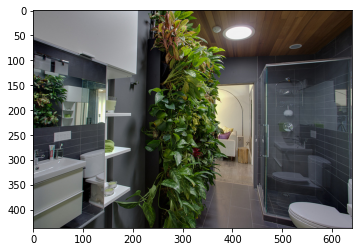

Q: Name the type of plant this is?
C: a bathroom with a toilet, sink, and shower stall
A: flower garden (score:0.5826758146286011)
GT: vine


In [32]:
mk_predictions(1)

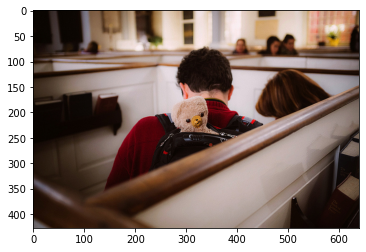

Q: What toy is this?
C: a young boy is holding a teddy bear in his hand
A: teddy bear (score:0.6841084957122803)
GT: stuffed animal


In [33]:
mk_predictions(2)

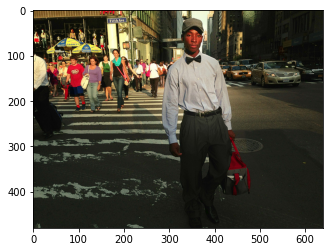

Q: What could this gentleman be carrying in that red bag?
C: a man in a white shirt and black pants holding a knife
A: 
infected devices (score:0.3395997881889343)
GT: cloth


In [35]:
mk_predictions(4)

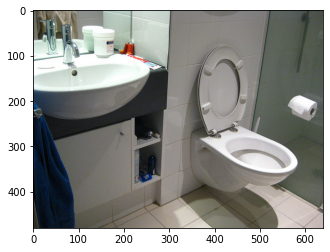

Q: Who leaves a toilet like this?
C: a white toilet sitting in a bathroom next to a sink
A: Donna Tinsley
 (score:0.44043591618537903)
GT: man


In [36]:
mk_predictions(5)

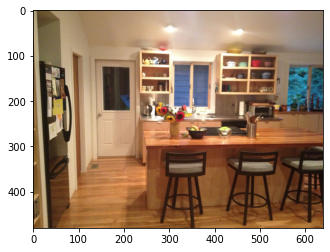

Q: A center affixed unit like this one in a kitchen is called a what?
C: a kitchen with a table, chairs and a refrigerator
A: Mannequin (score:0.833035409450531)
GT: island


In [37]:
mk_predictions(6)